In [7]:
import gym
from gym.wrappers import GrayScaleObservation, ResizeObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
import matplotlib.pyplot as plt
import os
from stable_baselines3 import PPO, DQN, A2C
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

In [8]:
main_dir = os.getcwd() # get main directory

# 1. INITIATE ENVIRONMENT

In [17]:
# Set atari environment using Gym library
env = gym.make("ALE/MsPacman-v5")
# Get the action from the selected environment
actions = env.get_action_meanings()

# Simulate Environment using Random Actions

In [8]:
# Set done flag to true
done = True
# Run loop for number of frames to run
for step in range(1000):
    if done:
        # Reset environment
        env.reset()
    # Get state, reward, done and info from steps
    state, reward, done, info = env.step(env.action_space.sample())
    # Render environment
    env.render()
# Close the environment after running the loop
env.close()

2023-01-04 01:12:10.052 python[12727:569774] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8375c5d9f0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2023-01-04 01:12:10.053 python[12727:569774] Warning: Expected min height of view: (<NSButton: 0x7f83775a3880>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2023-01-04 01:12:10.054 python[12727:569774] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8375f84fb0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2023-01-04 01:12:10.055 python[12727:569774] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8375f86620>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


# 2. Preprocess the Environment

In [18]:
# Grayscale the environment
env = GrayScaleObservation(env, keep_dim=True)
# Resize the observation
env = ResizeObservation(env, (84, 84))
# Wrap in dummy vectorized environment
env = DummyVecEnv([lambda: env])
# Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [19]:
state = env.reset()

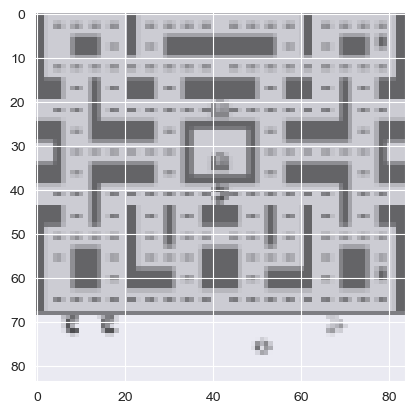

In [20]:
plt.imshow(state[0])

In [7]:
state.shape

(1, 84, 84, 4)

In [8]:
state, reward, done, info = env.step([env.action_space.sample()])

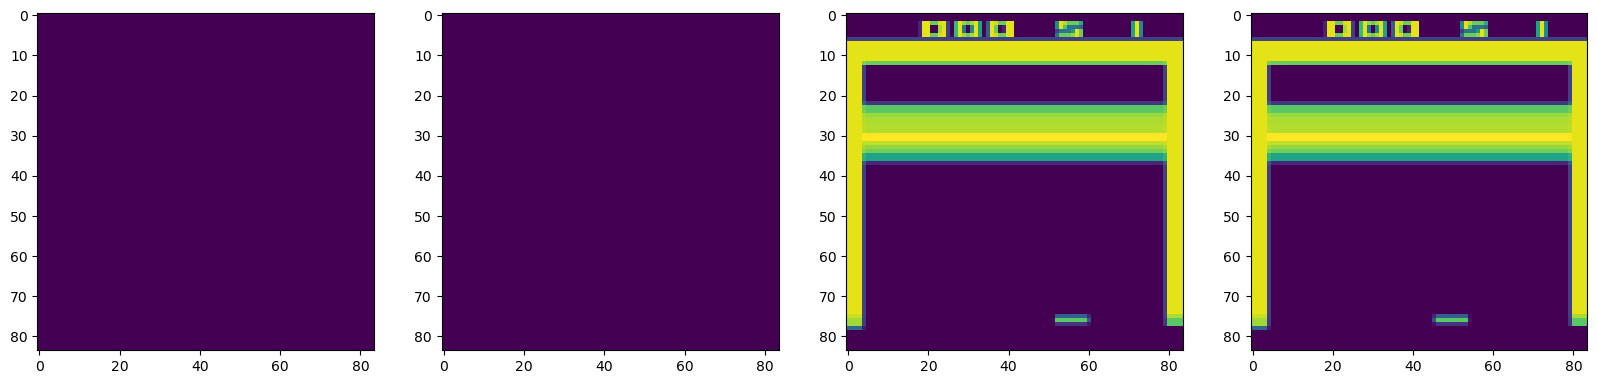

In [9]:
plt.figure(figsize=(20, 8))
for idx in range(state.shape[3]):
    plt.subplot(1, 4, idx+1)
    plt.imshow(state[0][:, :, idx])
plt.show()

# 3. TRAIN THE MODEL

In [14]:
# Callback class to save model after number of steps passed
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, algo, env_type, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        self.algo = algo
        self.env_type = env_type
    def _init_callback(self):
        if self.save_path is not None:
            # Create the directory if not exists to save to
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            # Specify path to save model
            model_path = os.path.join(self.save_path, '{}/{}/best_model_{}'.format(self.env_type, self.algo, self.n_calls))
            # Save model to the specified path
            self.model.save(model_path)

        return True

In [15]:
algo_type = "A2C" # RL algorithm to be implemented
env_name = env.envs[0].unwrapped.spec.id # Name of the Atatri environment
save_freq = 100000 # Checkpoint to save a trained model
CHECKPOINT_DIR = './train/' # Location to save the trained model checkpoint
LOG_DIR = './logs/{}/'.format(env_name) # Location to save the tesorboaord log

In [32]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=save_freq, save_path=CHECKPOINT_DIR, algo=algo_type, env_type=env_name)

# Select algorithm for training
if algo_type == "PPO":
    # Create PPO Model
    print("Running {} Model".format(algo_type))
    model = PPO("CnnPolicy", env, verbose=1, gamma=0.95, n_steps=256, ent_coef=0.0905168, learning_rate=0.00062211, vf_coef=0.042202, max_grad_norm=0.9, gae_lambda=0.99, n_epochs=5, clip_range=0.3, batch_size=256, tensorboard_log=LOG_DIR)
elif algo_type == "DQN":
    # Create DQN Model
    print("Running {} Model".format(algo_type))
    model = DQN("CnnPolicy", env, learning_rate=0.00062211, batch_size=256, gamma=0.95,  verbose=1, tensorboard_log=LOG_DIR)
elif algo_type == "A2C":
    # Create A2C Model
    print("Running {} Model".format(algo_type))
    model = A2C("CnnPolicy", env, gamma=0.95, n_steps=256, ent_coef=0.0905168, learning_rate=0.00062211, vf_coef=0.042202, max_grad_norm=0.9, gae_lambda=0.99, verbose=1, tensorboard_log=LOG_DIR)
else:
    print("Algorithm not found")

Running DQN Model
Using cpu device
Wrapping the env in a VecTransposeImage.


/Users/user/opt/anaconda3/envs/pacman_dqn_new/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 56.46GB > 8.24GB
  warnings.warn(


In [33]:
# Train the model to learn
model.learn(total_timesteps=200000, callback=callback)

Logging to ./logs/ALE/Breakout-v5/DQN_1
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.964    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 699      |
|    time_elapsed     | 1        |
|    total_timesteps  | 754      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.932    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 789      |
|    time_elapsed     | 1        |
|    total_timesteps  | 1435     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.893    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 837      |
|    time_elapsed     | 2        |
|    total_timesteps  | 2257     |
----------------------------------
---------------

/Users/user/opt/anaconda3/envs/pacman_dqn_new/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path 'train/ALE/Breakout-v5/DQN' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 412      |
|    fps              | 31       |
|    time_elapsed     | 3163     |
|    total_timesteps  | 100268   |
| train/              |          |
|    learning_rate    | 0.000622 |
|    loss             | 0.000172 |
|    n_updates        | 12566    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 416      |
|    fps              | 31       |
|    time_elapsed     | 3239     |
|    total_timesteps  | 101525   |
| train/              |          |
|    learning_rate    | 0.000622 |
|    loss             | 0.00025  |
|    n_updates        | 12881    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rat

# 4. EVALUATE THE MODEL

In [10]:
algo_type = "DQN" # RL algorithm to be implemented
env_name = env.envs[0].unwrapped.spec.id # Name of the Atatri environment
episodes = 10 # Specify number of episodes the game plays for
reward_info = [] # Store the reward info
path_file = os.path.join(main_dir, "train/{}/{}/learning.data".format(env_name, algo_type)) # Path to save each learning data
file_results = open(path_file, 'w') # create a new file from the path

In [11]:
# Load model from directory
if algo_type == "PPO":
    print("PPO Model Loading...")
    model = PPO.load("./train/{}/{}/best_model_200000".format(env_name, algo_type))
elif algo_type == "DQN":
    print("DQN Model Loading...")
    model = DQN.load("./train/{}/{}/best_model_200000".format(env_name, algo_type))
elif algo_type == "A2C":
    print("A2C Model Loading...")
    model = A2C.load("./train/{}/{}/best_model_200000".format(env_name, algo_type))
else:
    print("Not Found")

DQN Model Loading...


/Users/user/opt/anaconda3/envs/pacman_dqn_new/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 56.46GB > 5.71GB
  warnings.warn(


In [14]:
# Reset the environment
state = env.reset()
# Loop to run the game for a specified number of episodes
for episode in range(1, episodes+1):
    score = 0 # Keep track of the score of each episode
    done = False # Set the done flag as False to begin playing to game
    while not done:
        # Action is predicted based on the trained model and not chosen at random
        action = model.predict(state)[0]
        # Step is taken based on predicted action
        state, reward, done, info = env.step(action)
        # Update the score based on the reward for each episode
        score+=reward
        # Append the reward of an episode to the reward info
        reward_info.append(reward)
        # Render the environment
        env.render()
        # Check if the game is done
        if done:
            # Store the reward info into a numpy array
            all_rewards = np.array(reward_info)
            # Get the mean of the rewards
            all_rewards = np.mean(all_rewards)
            # Write into the learning data file that is created for the policy
            file_results.write(','.join(all_rewards.flatten().astype('str')) + "\n")
            file_results.flush()
    print("Episode: {}  -------  Reward: {}".format(episode, score[0]))

Episode: 1  -------  Reward: 3.0
Episode: 2  -------  Reward: 2.0
Episode: 3  -------  Reward: 2.0
Episode: 4  -------  Reward: 11.0
Episode: 5  -------  Reward: 2.0
Episode: 6  -------  Reward: 3.0
Episode: 7  -------  Reward: 3.0
Episode: 8  -------  Reward: 1.0
Episode: 9  -------  Reward: 3.0
Episode: 10  -------  Reward: 7.0


# REWARDS PLOT

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import figure
from pylab import rcParams
import glob
import binascii
import palettable.colorbrewer.qualitative

In [38]:
plot_colors = palettable.colorbrewer.qualitative.Set3_5.mpl_colors
plot_colors = palettable.colorbrewer.qualitative.Dark2_7.mpl_colors

params = {
    'axes.labelsize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.figsize': [10.8, 4.9]
}
rcParams.update(params)
episode_length=500

In [28]:
def check_file_type(filepath):
    with open(filepath, 'rb') as test_f:
        return binascii.hexlify(test_f.read(2)) == b'1f8b'

In [44]:
def load_learning_data(path, simplify=False):
    main_data = []
    min_result=float('inf')
    all_results=[]
    for directory in glob.iglob(path+'**/learning.data', recursive=True):
        data = []
        if check_file_type(directory):
            data = pd.read_csv(directory, compression="gzip", sep=",")
        else:
            data = pd.read_csv(directory, sep=",")
        data = np.asarray(data)
        data = data/episode_length
        min_result=min(min_result, data.shape[0])
        all_results.append(data.shape[0])

        main_data.append(data)

    if len(main_data) == 0:
        print('no data at', path)
        raise()
        exit(1)

    for i in range(len(main_data)):
        main_data[i]=main_data[i][0:min_result,:]

    main_data = np.array(main_data)
    main_data_2 = main_data
    main_data = main_data_2.sum(axis=2)
    if simplify:
        return main_data
    summed_all=main_data_2.mean()
    return np.array([summed_all]).transpose()

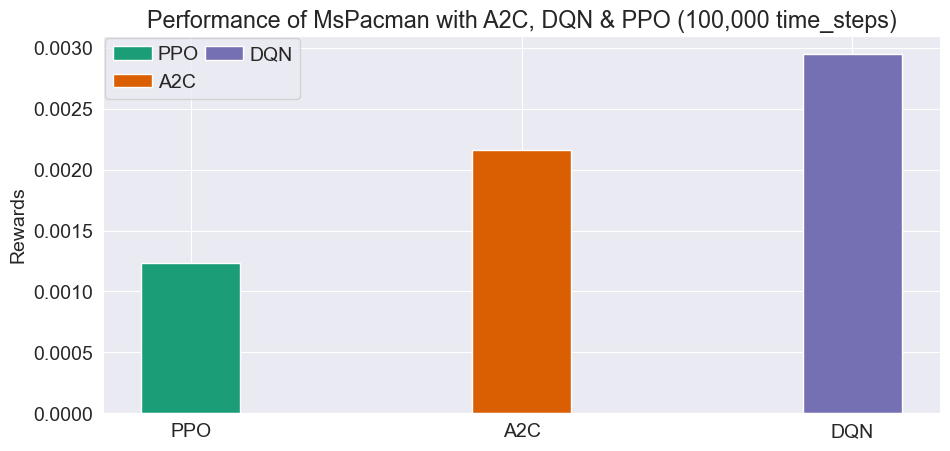

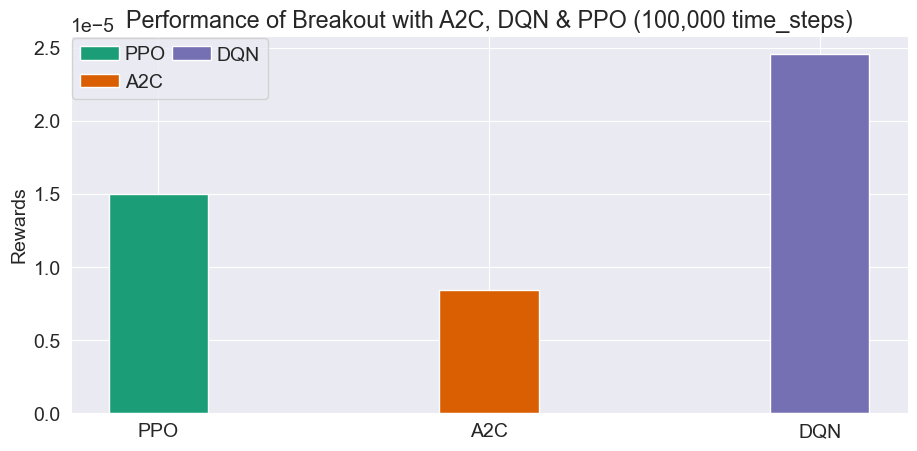

In [45]:
drawlist=()

# Get the path of the files
get_file_path = os.getcwd()

if True:
    fig=figure()
    ax=fig.add_subplot(111)
    all_paths=[
        (get_file_path + "/train/ALE/MsPacman-v5/PPO", "PPO"),
        (get_file_path + "/train/ALE/MsPacman-v5/A2C", "A2C"),
        (get_file_path + "/train/ALE/MsPacman-v5/DQN", "DQN"),
    ]
    names = ["PPO", "A2C", "DQN"]
    width = 0.3  # the width of the bars
    x = np.arange(1)  # the label locations

    dplot=[]
    for (p, _) in all_paths:
        dplot.append(load_learning_data(p))

    for i in range(len(all_paths)):
        ax.bar(x + i + width, np.mean(dplot[i], axis=0), width, label=all_paths[i][1], color=plot_colors[i], yerr=np.std(dplot[i], axis=0))

    x = np.arange(len(names))
    ax.legend(loc="best", ncol=2, handletextpad=0.3, columnspacing=0.3, borderaxespad=0.1)
    ax.set_xticks(x+0.3)
    ax.set_xticklabels(names)
    ax.set_title('Performance of MsPacman with A2C, DQN & PPO (100,000 time_steps)')
    ax.set_ylabel('Rewards')
    plt.savefig('ms_pacman_perf_100000.png')

if True:
    fig=figure()
    ax=fig.add_subplot(111)
    all_paths=[
        (get_file_path + "/train/ALE/Breakout-v5/PPO", "PPO"),
        (get_file_path + "/train/ALE/Breakout-v5/A2C", "A2C"),
        (get_file_path + "/train/ALE/Breakout-v5/DQN", "DQN"),
    ]
    names = ["PPO", "A2C", "DQN"]
    width = 0.3  # the width of the bars
    x = np.arange(1)  # the label locations

    dplot=[]
    for (p, _) in all_paths:
        dplot.append(load_learning_data(p))

    for i in range(len(all_paths)):
        ax.bar(x + i + width, np.mean(dplot[i], axis=0), width, label=all_paths[i][1], color=plot_colors[i], yerr=np.std(dplot[i], axis=0))

    x = np.arange(len(names))
    ax.legend(loc="best", ncol=2, handletextpad=0.3, columnspacing=0.3, borderaxespad=0.1)
    ax.set_xticks(x+0.3)
    ax.set_xticklabels(names)
    ax.set_title('Performance of Breakout with A2C, DQN & PPO (100,000 time_steps)')
    ax.set_ylabel('Rewards')
    plt.savefig('breakout_perf_100000.png')